In [1]:
#pip install torchsummary

In [2]:
# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# # For mutliple devices (GPUs: 4, 5, 6, 7)
# os.environ["CUDA_VISIBLE_DEVICES"] = "7"


In [21]:

from models import resnet
from models.lenet import LeNetwork

import random
import numpy as np
import torch
from torch import nn, optim
import learn2learn as l2l
from torchvision.models import resnet18
import torchvision
from torchvision import transforms
from learn2learn.data import TaskDataset
from learn2learn.data.transforms import (NWays,
                                         KShots,
                                         LoadData,
                                         RemapLabels,
                                         ConsecutiveLabels)
import torch.nn.functional as F
import random
from torchsummary import torchsummary
import higher
# from jupyterplot import ProgressPlot
import numpy as np
import time
# import mlogger
import utils
import argparse


In [4]:
# import sys,os,argparse
# # def arg_parser():
    
# parser = argparse.ArgumentParser('MAML with Higher')

# # General
# general_params = parser.add_argument_group('General')
# general_params.add_argument('--data', type=str, default="./data",
#                             help='Path to the folder the data is downloaded to.')
# general_params.add_argument('--dataset', type=str,
#                             choices=["omniglot", "mini-imagenet", "fc100",
#                                      "cifarfs", "tiered-imagenet"], default='omniglot',
#                             help='Name of the dataset (default: omniglot).')

# meta_params = parser.add_argument_group('Meta Learning Parameters')
# meta_params.add_argument('--ways', type=int, default=5,
#                             help='Number of classes per task (N in "N-way", default: 5).')
# meta_params.add_argument('--shots', type=int, default=1,
#                             help='Number of training example per class (k in "k-shot", default: 5).')
# meta_params.add_argument('--adaptation-steps', type=int, default=1,
#                             help='Number of adaptation steps on meta-train datasets.')
# meta_params.add_argument('--num-tasks', type=int, default=32,
#                           help='Number of tasks to sample from task distribution.')
# meta_params.add_argument('--first-order', action='store_true',
#                           help='Use the first order approximation, do not use highers-order '
#                                'derivatives during meta-optimization.')
# meta_params.add_argument('--meta-lr', type=float, default=0.001,
#                           help='Learning rate for the meta-optimizer (optimization of the outer '
#                                'loss). The default optimizer is Adam (default: 1e-3).')
# meta_params.add_argument('--fast-lr', type=float, default=0.1,
#                           help='Learning rate for the meta-optimizer (optimization of the outer '
#                                'loss). The default optimizer is Adam (default: 1e-3).')
# meta_params.add_argument('--num-test-task', type=int, default=32,
#                             help='Number of test task used to calculate meta test and meta val')


# # Model
# model_params = parser.add_argument_group('Model')
# model_params.add_argument('--input', type=int, default=32,
#                           help='Input to dimension')
# model_params.add_argument('--fine-tune', type=int, default=0,
#                           help='Only meta learn the FC layer')

# # Optimization
# optim_params = parser.add_argument_group('Optimization')
# optim_params.add_argument('--num-epochs', type=int, default=50000,
#                           help='Number of epochs of meta-training (default: 50000).')
# optim_params.add_argument('--seed', type=int, default=utils.fix_seeds(),
#                           help='Number of epochs of meta-training (default: 101).')




# # Misc
# misc = parser.add_argument_group('Misc')
# misc.add_argument('--num-workers', type=int, default=4,
#                   help='Number of workers to use for data-loading (default: 1).')
# misc.add_argument('--device', type=str, default=utils.get_compute_device(), help="Compute device information")


# # Visualization
# viz = parser.add_argument_group('Misc')
# viz.add_argument('--wand_project', type=str, default="Github_Rapo",
#                   help='Wandb project name should go here')
# viz.add_argument('--username', type=str, default="hikmatkhan",
#                   help='Wandb username should go here')
# viz.add_argument('--wandb_logging', type=bool, default=True,
#                   help='If True, Logs will be reported on wandb.')
# viz.add_argument('--verbose', action='store_true')
# #     args = parser.parse_args()
# #     return parser.parse_args()
# # args = parser.parse_args()


In [5]:
# def main(argv):
#     print(argv)
    
# main(sys.argv)

In [6]:
#No randomization
seed = 101
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device('cpu')
if torch.cuda.device_count():
    torch.cuda.manual_seed(seed)
    device = torch.device('cuda')
    print("Device:", device)

Device: cuda


In [7]:
# #Dataset
# # transforms
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))])

# dataset = torchvision.datasets.MNIST(root="data", train=True, download=True, transform=transform)



In [8]:
# #MetaDataset MNIST or Custom Dataset
# dataset = l2l.data.MetaDataset(dataset)
# ways = 10
# shots = 1
# transforms = [
#     NWays(dataset, n=ways),
#     KShots(dataset, k=shots),
#     LoadData(dataset),
# ]
# tasksets = TaskDataset(dataset, transforms, num_tasks=5)
# # MetaDataset Sampling
# for task in tasksets:
#     X, y = task
#     print(y)

In [9]:
#Builtin-MetaDatasets
dataset_name = "omniglot"
# "omniglot"
# "mini-imagenet", 
# "fc100", 
# "cifarfs", 
# "tiered-imagenet"

ways = 5
shots = 1
meta_batch= 8
# Create Tasksets using the benchmark interface
tasksets = l2l.vision.benchmarks.get_tasksets(dataset_name,
                                              train_samples=2*shots,
                                              train_ways=ways,
                                              test_samples=2*shots,
                                              test_ways=ways,
                                              root='~/data',
                                              num_tasks=2000)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
# Separate data into adaptation/evalutation sets
# adaptation_indices = np.zeros(X.size(0), dtype=bool)
# adaptation_indices[np.arange(shots*ways) * 2] = True
# evaluation_indices = torch.from_numpy(~adaptation_indices)
# adaptation_indices = torch.from_numpy(adaptation_indices)


X.size: torch.Size([10, 1, 28, 28])


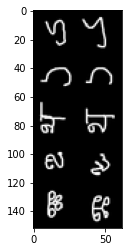

In [11]:
import matplotlib.pylab as plt
from torchvision import utils
X, y = tasksets.train.sample()
print("X.size:", X.size())
grid = utils.make_grid(X, nrow=shots * 2)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [12]:
def get_indices(X, ways, shots):
    # Separate data into Meta-Train/Meta-Test sets
    meta_train_indices = np.zeros(X.size(0), dtype=bool)
    # print("X:", X.size())
    meta_train_indices[np.arange(shots * ways) * 2] = True
    meta_test_indices = torch.from_numpy(~meta_train_indices)
    meta_train_indices = torch.from_numpy(meta_train_indices)
    return meta_train_indices, meta_test_indices

def accuracy(predictions, targets):
    predictions = predictions.argmax(dim=1).view(targets.shape)
    return (predictions == targets).sum().float() / targets.size(0)

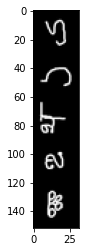

In [13]:
meta_train_indices, meta_test_indices = get_indices(X=X, ways=ways, shots=shots)
#Adaptation Data
grid = utils.make_grid(X[meta_train_indices], nrow=shots)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

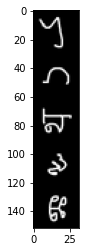

In [14]:
#Adaptation Data
grid = utils.make_grid(X[meta_test_indices], nrow=shots)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

Validation: tensor([1, 1, 2, 2, 3, 3, 0, 0, 4, 4])


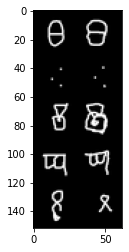

In [15]:
X, y = tasksets.validation.sample()
print("Validation:", y)
grid = utils.make_grid(X, nrow=shots*2)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

Test: tensor([4, 4, 2, 2, 3, 3, 0, 0, 1, 1])


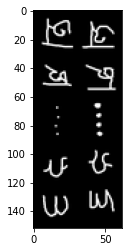

In [16]:
X, y = tasksets.test.sample()
print("Test:", y)
grid = utils.make_grid(X, nrow=shots * 2)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [17]:
# model = resnet.ResNet18S(out_dim=ways).to(device)
model = LeNetwork(out_dim=10, in_channel=1, img_sz=28)#.to(device)
print(model)
# model = resnet18(pretrained=True).to(device)
# for param in model.parameters():
#     param.requires_grad = False
# num_ftrs = model.fc.in_features

# num_ftrs 
# model.fc = nn.Linear(num_ftrs, ways).to(device)

# print(model(torch.rand((1,3,84,84)).to(device)))
# torchsummary.summary(model, input_size= (3, 84, 84))

LeNet(
  (conv): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Sequential(
    (0): Linear(in_features=2450, out_features=500, bias=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (last): Linear(in_features=500, out_features=10, bias=True)
)


In [18]:
# print(model.conv1.weight[0].grad)

In [19]:


# def main(argv):
    

In [20]:
meta_lr = 0.001
fast_lr = 0.01
optim_meta = optim.Adam(model.parameters(), lr=meta_lr)
epochs = 1000
WANDB_LOGGER = False
adaptation_steps = 1

if(WANDB_LOGGER):
    import wandb
    wandb.init(project="TestRun", entity="hikmatkhan-", reinit=True)
    wandb.watch(model, log_freq=10)
    wandb.log({"Dataset":dataset_name,
              "Ways":ways,
              "Shots":shots,
              "Meta Batch": meta_batch,
              "Meta_lr": meta_lr,
              "Fast_lr": fast_lr,
              "Adaptation Step": adaptation_steps})
#             if __name__ == "__main__":

#     meta_train_spt_loss = mlogger.metric.Average()
#     meta_train_spt_acc = mlogger.metric.Average()
#     meta_train_qry_loss = mlogger.metric.Average()
#     meta_train_qry_acc = mlogger.metric.Average()

for e in range(epochs):
    optim_meta.zero_grad()
    model.train()
    meta_train_loss = mlogger.metric.Average()
    meta_train_acc = mlogger.metric.Average()
    meta_val_loss = mlogger.metric.Average()
    meta_val_acc = mlogger.metric.Average()
    meta_test_loss = mlogger.metric.Average()
    meta_test_acc = mlogger.metric.Average()
    for t in range(meta_batch):
        X, y = tasksets.train.sample()

#         X, y = X.to(device), y.to(device)
#             print(X.size())
        meta_train_indices, meta_test_indices = get_indices(X=X, ways=ways, shots=shots)
        optim_fast = optim.Adam(model.parameters(), lr=fast_lr)
        with higher.innerloop_ctx(model=model, opt=optim_fast, copy_initial_weights=False
                                 ) as (fmodel, diff_opp):

            for a in range(adaptation_steps):
                y_prd = fmodel(X[meta_train_indices])
                meta_train_spt_loss = F.cross_entropy(y_prd, y[meta_train_indices])
                diff_opp.step(meta_train_spt_loss)

            y_prd = fmodel(X[meta_test_indices])
            meta_train_acc.update(accuracy(y_prd, y[meta_test_indices]))
            meta_train_qry_loss = F.cross_entropy(y_prd, y[meta_test_indices])
            meta_train_loss.update(meta_train_qry_loss.detach().cpu().item())
            meta_train_qry_loss.backward()

        del X, y, meta_train_indices, meta_test_indices
    optim_meta.step()
    if(WANDB_LOGGER):
        wandb.log({"Meta Update": e})
    print("Meta-Update")

    for t in range(meta_batch):
        model.eval()
        X_val, y_val = tasksets.validation.sample()
#         X_val, y_val = X_val.to(device), y_val.to(device)

#             print(X.size())
        meta_train_indices, meta_test_indices = get_indices(X=X_val, ways=ways, shots=shots)
        optim_fast = optim.Adam(model.parameters(), lr=fast_lr)
        with higher.innerloop_ctx(model=model, opt=optim_fast,  track_higher_grads=False
                                 ) as (fmodel, diff_opp):


#                 print(fmodel.conv1.weight[0].grad)
            for a in range(adaptation_steps):
                y_prd = fmodel(X_val[meta_train_indices])
#                     a_meta_train_spt_acc.update(accuracy(y_prd, y[meta_train_indices]))
                meta_val_spt_loss = F.cross_entropy(y_prd, y_val[meta_train_indices])
#                     a_meta_train_spt_loss.update(meta_train_spt_loss.detach().cpu().item())
                diff_opp.step(meta_val_spt_loss)
#                 meta_train_spt_loss.update(a_meta_train_spt_loss.value)
#                 meta_train_spt_acc.update(a_meta_train_spt_acc.value)

            y_prd = fmodel(X_val[meta_test_indices])
            meta_val_acc.update(accuracy(y_prd, y_val[meta_test_indices]))
            meta_val_qry_loss = F.cross_entropy(y_prd, y_val[meta_test_indices])
            meta_val_loss.update(meta_val_qry_loss.detach().cpu().item())


        del X_val, y_val, meta_train_indices, meta_test_indices
    
    for t in range(meta_batch):
        model.eval()
        X_test, y_test = tasksets.test.sample()
#         X_test, y_test = X_test.to(device), y_test.to(device)

        meta_train_indices, meta_test_indices = get_indices(X=X_test, ways=ways, shots=shots)
        optim_fast = optim.Adam(model.parameters(), lr=fast_lr)
        with higher.innerloop_ctx(model=model, opt=optim_fast,  track_higher_grads=False
                                 ) as (fmodel, diff_opp):


#                 print(fmodel.conv1.weight[0].grad)
            for a in range(adaptation_steps):
                y_prd = fmodel(X_test[meta_train_indices])
#                     a_meta_train_spt_acc.update(accuracy(y_prd, y[meta_train_indices]))
                meta_test_spt_loss = F.cross_entropy(y_prd, y_test[meta_train_indices])
#                     a_meta_train_spt_loss.update(meta_train_spt_loss.detach().cpu().item())
                diff_opp.step(meta_test_spt_loss)
#                 meta_train_spt_loss.update(a_meta_train_spt_loss.value)
#                 meta_train_spt_acc.update(a_meta_train_spt_acc.value)

            y_prd = fmodel(X_test[meta_test_indices])
            meta_test_acc.update(accuracy(y_prd, y_test[meta_test_indices]))
            meta_test_qry_loss = F.cross_entropy(y_prd, y_test[meta_test_indices])
            meta_test_loss.update(meta_test_qry_loss.detach().cpu().item())
            
            del X_test, y_test, meta_train_indices, meta_test_indices


#                 meta_train_qry_loss.backward()

    if(WANDB_LOGGER):
        wandb.log({
               "Meta Train Acc": meta_train_acc.value,
               "Meta Train Loss": meta_train_loss.value,
                "Meta Val Acc": meta_val_acc.value,
                "Meta Val Loss": meta_val_loss.value,
                "Meta Test Acc": meta_test_acc.value,
                "Meta Test Loss": meta_test_loss.value
               })
    print("Epoch|", e, "|", "Meta Train Acc:", meta_train_acc.value, " Meta Train Loss:", meta_train_loss.value,
         "Meta Val Acc:", meta_val_acc.value, " Meta Val Loss:", meta_val_loss.value,
         "Meta Test Acc:", meta_test_acc.value, " Meta Test Loss:", meta_test_loss.value)


    meta_train_loss.reset()
    meta_train_acc.reset()
    meta_val_loss.reset()
    meta_val_acc.reset()
    meta_test_loss.reset()
    meta_test_acc.reset()

                
    

Meta-Update
Epoch| 0 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.8190755397081375 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 2.085274636745453 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 2.1640587151050568
Meta-Update
Epoch| 1 | Meta Train Acc: 0.8500000052154064  Meta Train Loss: 0.48278322070837015 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 1.8997284024953842 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 1.9064059555530548
Meta-Update
Epoch| 2 | Meta Train Acc: 0.7500000149011612  Meta Train Loss: 0.9099836871027946 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 1.8859403282403946 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 1.880121573805809
Meta-Update
Epoch| 3 | Meta Train Acc: 0.7250000163912773  Meta Train Loss: 0.7860988304018974 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.8143321871757507 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 1.813465654850006
Meta-Update
Epoch| 4 | Meta Train Acc: 0.7500000149011612  Meta

Epoch| 35 | Meta Train Acc: 0.6500000134110451  Meta Train Loss: 1.114253643900156 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 1.7151868492364883 Meta Test Acc: 0.3500000052154064  Meta Test Loss: 2.0374177396297455
Meta-Update
Epoch| 36 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.7821580246090889 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 1.932155892252922 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 1.9540771096944805
Meta-Update
Epoch| 37 | Meta Train Acc: 0.6500000096857548  Meta Train Loss: 0.9663139339536427 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.0173117965459824 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 1.802576407790184
Meta-Update
Epoch| 38 | Meta Train Acc: 0.7750000134110451  Meta Train Loss: 0.7324781212955713 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 1.869158461689949 Meta Test Acc: 0.3000000044703483  Meta Test Loss: 2.4400951862335205
Meta-Update
Epoch| 39 | Meta Train Acc: 0.8750000074505806  Meta Train Loss: 0

Meta-Update
Epoch| 71 | Meta Train Acc: 0.6000000145286322  Meta Train Loss: 1.148101523518562 Meta Val Acc: 0.2750000059604645  Meta Val Loss: 2.3085964173078537 Meta Test Acc: 0.3250000048428774  Meta Test Loss: 1.8079681992530823
Meta-Update
Epoch| 72 | Meta Train Acc: 0.7250000089406967  Meta Train Loss: 0.8058118131011723 Meta Val Acc: 0.42500001192092896  Meta Val Loss: 2.014955893158913 Meta Test Acc: 0.1750000026077032  Meta Test Loss: 2.299595907330513
Meta-Update
Epoch| 73 | Meta Train Acc: 0.6000000070780516  Meta Train Loss: 1.1499328538775444 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 2.4334052056074142 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 2.175625056028366
Meta-Update
Epoch| 74 | Meta Train Acc: 0.7750000096857548  Meta Train Loss: 0.9383669570088385 Meta Val Acc: 0.3250000048428774  Meta Val Loss: 2.095593512058258 Meta Test Acc: 0.37500000745058054  Meta Test Loss: 2.007402613759041
Meta-Update
Epoch| 75 | Meta Train Acc: 0.7000000141561031  Meta T

Epoch| 106 | Meta Train Acc: 0.6250000111758709  Meta Train Loss: 1.026522345840931 Meta Val Acc: 0.3250000048428774  Meta Val Loss: 2.2242001742124557 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 2.488287001848221
Meta-Update
Epoch| 107 | Meta Train Acc: 0.5750000178813934  Meta Train Loss: 1.112684041261673 Meta Val Acc: 0.32500000670552254  Meta Val Loss: 2.3295775800943375 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 2.7156999111175537
Meta-Update
Epoch| 108 | Meta Train Acc: 0.6750000156462193  Meta Train Loss: 0.9407782480120659 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 2.626925006508827 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 2.7544930279254913
Meta-Update
Epoch| 109 | Meta Train Acc: 0.7000000141561031  Meta Train Loss: 0.8305104598402978 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.3683429956436157 Meta Test Acc: 0.2750000059604645  Meta Test Loss: 2.740398332476616
Meta-Update
Epoch| 110 | Meta Train Acc: 0.7250000108033419  Meta Train L

Meta-Update
Epoch| 141 | Meta Train Acc: 0.6750000137835741  Meta Train Loss: 0.8549863751977681 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 3.511562168598175 Meta Test Acc: 0.3250000067055225  Meta Test Loss: 2.965919718146324
Meta-Update
Epoch| 142 | Meta Train Acc: 0.675000011920929  Meta Train Loss: 0.8648459538817406 Meta Val Acc: 0.30000000633299345  Meta Val Loss: 3.5054999291896825 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 3.360311895608902
Meta-Update
Epoch| 143 | Meta Train Acc: 0.7250000163912773  Meta Train Loss: 0.9296324625611305 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 2.6890230923891068 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 3.330185860395431
Meta-Update
Epoch| 144 | Meta Train Acc: 0.8250000104308128  Meta Train Loss: 0.5367282549850643 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 3.455386400222778 Meta Test Acc: 0.3000000063329935  Meta Test Loss: 2.696290999650955
Meta-Update
Epoch| 145 | Meta Train Acc: 0.7500000111758709  M

Meta-Update
Epoch| 176 | Meta Train Acc: 0.6500000096857548  Meta Train Loss: 1.0646700542420149 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 1.6392969638109207 Meta Test Acc: 0.35000000707805157  Meta Test Loss: 1.5355116724967957
Meta-Update
Epoch| 177 | Meta Train Acc: 0.6250000111758709  Meta Train Loss: 1.1150303855538368 Meta Val Acc: 0.32500000670552254  Meta Val Loss: 1.5889165252447128 Meta Test Acc: 0.3500000070780515  Meta Test Loss: 1.5287762731313705
Meta-Update
Epoch| 178 | Meta Train Acc: 0.8250000104308128  Meta Train Loss: 0.8798409998416902 Meta Val Acc: 0.3000000044703483  Meta Val Loss: 1.665513888001442 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 1.5574142187833788
Meta-Update
Epoch| 179 | Meta Train Acc: 0.8750000074505806  Meta Train Loss: 0.5155262462794781 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 1.7371066212654114 Meta Test Acc: 0.35000000894069677  Meta Test Loss: 1.588944360613823
Meta-Update
Epoch| 180 | Meta Train Acc: 0.62500001676380

Meta-Update
Epoch| 211 | Meta Train Acc: 0.6000000108033418  Meta Train Loss: 1.4264088310301304 Meta Val Acc: 0.3000000063329935  Meta Val Loss: 2.1042650192976 Meta Test Acc: 0.2750000059604644  Meta Test Loss: 1.7649012207984924
Meta-Update
Epoch| 212 | Meta Train Acc: 0.6500000059604645  Meta Train Loss: 1.2321058372035623 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 1.6587057411670683 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 2.0526842772960663
Meta-Update
Epoch| 213 | Meta Train Acc: 0.5750000067055226  Meta Train Loss: 1.1417272314429283 Meta Val Acc: 0.3000000063329935  Meta Val Loss: 1.9918358474969862 Meta Test Acc: 0.2750000059604645  Meta Test Loss: 2.6473390311002736
Meta-Update
Epoch| 214 | Meta Train Acc: 0.8000000081956387  Meta Train Loss: 0.8414981309324501 Meta Val Acc: 0.32500000670552254  Meta Val Loss: 1.6484137177467344 Meta Test Acc: 0.30000000633299345  Meta Test Loss: 1.886133223772049
Meta-Update
Epoch| 215 | Meta Train Acc: 0.6000000145286323  

Meta-Update
Epoch| 246 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.8358512111008167 Meta Val Acc: 0.3750000074505806  Meta Val Loss: 1.7449391484260557 Meta Test Acc: 0.30000000633299345  Meta Test Loss: 1.7299385368824005
Meta-Update
Epoch| 247 | Meta Train Acc: 0.7500000149011612  Meta Train Loss: 0.5206518024206161 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 1.8413626700639727 Meta Test Acc: 0.2750000059604645  Meta Test Loss: 1.7381151020526886
Meta-Update
Epoch| 248 | Meta Train Acc: 0.6750000156462193  Meta Train Loss: 1.0031983852386475 Meta Val Acc: 0.32500000670552254  Meta Val Loss: 1.739906758069992 Meta Test Acc: 0.3500000070780515  Meta Test Loss: 1.6512356400489807
Meta-Update
Epoch| 249 | Meta Train Acc: 0.6500000115483999  Meta Train Loss: 0.9166269320994617 Meta Val Acc: 0.4000000078231096  Meta Val Loss: 1.6285718530416489 Meta Test Acc: 0.3250000048428774  Meta Test Loss: 1.8222747296094894
Meta-Update
Epoch| 250 | Meta Train Acc: 0.7750000134110451

Meta-Update
Epoch| 281 | Meta Train Acc: 0.700000012293458  Meta Train Loss: 0.7749415133148432 Meta Val Acc: 0.5000000111758709  Meta Val Loss: 1.5894807130098343 Meta Test Acc: 0.42500001192092896  Meta Test Loss: 1.645890161395073
Meta-Update
Epoch| 282 | Meta Train Acc: 0.6500000078231096  Meta Train Loss: 0.9889634661376476 Meta Val Acc: 0.4000000096857548  Meta Val Loss: 1.6050412058830263 Meta Test Acc: 0.37500000745058065  Meta Test Loss: 1.5985355824232101
Meta-Update
Epoch| 283 | Meta Train Acc: 0.5750000141561031  Meta Train Loss: 1.4639092832803724 Meta Val Acc: 0.3750000055879355  Meta Val Loss: 1.5439803004264832 Meta Test Acc: 0.40000001154840004  Meta Test Loss: 1.5809932202100756
Meta-Update
Epoch| 284 | Meta Train Acc: 0.7250000108033419  Meta Train Loss: 0.8548262361437083 Meta Val Acc: 0.32500000670552254  Meta Val Loss: 1.5940891653299332 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 1.837862178683281
Meta-Update
Epoch| 285 | Meta Train Acc: 0.6500000171363354

Meta-Update
Epoch| 316 | Meta Train Acc: 0.8500000089406968  Meta Train Loss: 0.45867759548127657 Meta Val Acc: 0.4000000078231097  Meta Val Loss: 1.6688988506793974 Meta Test Acc: 0.3250000048428774  Meta Test Loss: 1.734672874212265
Meta-Update
Epoch| 317 | Meta Train Acc: 0.8000000081956387  Meta Train Loss: 0.9040837772190569 Meta Val Acc: 0.4250000100582838  Meta Val Loss: 1.6786822974681854 Meta Test Acc: 0.475000012665987  Meta Test Loss: 1.6583646833896637
Meta-Update
Epoch| 318 | Meta Train Acc: 0.7000000085681678  Meta Train Loss: 0.8073651478625834 Meta Val Acc: 0.375000011175871  Meta Val Loss: 1.7118813693523407 Meta Test Acc: 0.4000000096857548  Meta Test Loss: 1.6506877839565277
Meta-Update
Epoch| 319 | Meta Train Acc: 0.6000000145286323  Meta Train Loss: 1.19619482383132 Meta Val Acc: 0.32500000670552254  Meta Val Loss: 1.5545760691165924 Meta Test Acc: 0.47500001452863216  Meta Test Loss: 1.6192930191755295
Meta-Update
Epoch| 320 | Meta Train Acc: 0.8250000104308128  M

Meta-Update
Epoch| 351 | Meta Train Acc: 0.7750000078231096  Meta Train Loss: 0.727204461582005 Meta Val Acc: 0.3750000074505806  Meta Val Loss: 1.6012362241744995 Meta Test Acc: 0.32500000670552254  Meta Test Loss: 1.6040453910827637
Meta-Update
Epoch| 352 | Meta Train Acc: 0.8500000052154063  Meta Train Loss: 0.47765978146344423 Meta Val Acc: 0.42500000819563866  Meta Val Loss: 1.5260597467422483 Meta Test Acc: 0.35000000707805157  Meta Test Loss: 1.619032621383667
Meta-Update
Epoch| 353 | Meta Train Acc: 0.7750000134110451  Meta Train Loss: 0.710731565952301 Meta Val Acc: 0.30000000633299345  Meta Val Loss: 1.5966063290834427 Meta Test Acc: 0.37500001117587095  Meta Test Loss: 1.5316427052021027
Meta-Update
Epoch| 354 | Meta Train Acc: 0.9000000059604645  Meta Train Loss: 0.45924477279186254 Meta Val Acc: 0.37500000931322575  Meta Val Loss: 1.4940729737281797 Meta Test Acc: 0.4000000115483999  Meta Test Loss: 1.5607214570045471
Meta-Update
Epoch| 355 | Meta Train Acc: 0.750000011175

Meta-Update
Epoch| 386 | Meta Train Acc: 0.6000000108033418  Meta Train Loss: 0.9754374921321869 Meta Val Acc: 0.3750000074505806  Meta Val Loss: 1.5884086489677427 Meta Test Acc: 0.45000001043081284  Meta Test Loss: 1.610323041677475
Meta-Update
Epoch| 387 | Meta Train Acc: 0.8250000067055224  Meta Train Loss: 0.5407427214086057 Meta Val Acc: 0.42500001192092896  Meta Val Loss: 1.5700397640466688 Meta Test Acc: 0.4000000059604645  Meta Test Loss: 1.4331906884908678
Meta-Update
Epoch| 388 | Meta Train Acc: 0.6500000134110451  Meta Train Loss: 1.038418927229941 Meta Val Acc: 0.37500000931322575  Meta Val Loss: 1.443621575832367 Meta Test Acc: 0.4250000081956387  Meta Test Loss: 1.5627203583717346
Meta-Update
Epoch| 389 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.8747826993931085 Meta Val Acc: 0.2750000059604644  Meta Val Loss: 1.6034749448299406 Meta Test Acc: 0.35000000707805157  Meta Test Loss: 1.513393759727478
Meta-Update
Epoch| 390 | Meta Train Acc: 0.7500000149011612 

Meta-Update
Epoch| 421 | Meta Train Acc: 0.7250000070780516  Meta Train Loss: 0.6141934348270298 Meta Val Acc: 0.42500001005828386  Meta Val Loss: 1.5783690810203552 Meta Test Acc: 0.32500000856816774  Meta Test Loss: 1.5351476669311526
Meta-Update
Epoch| 422 | Meta Train Acc: 0.8250000104308128  Meta Train Loss: 0.6632789541035891 Meta Val Acc: 0.3750000093132257  Meta Val Loss: 1.5570454746484756 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 1.5817658454179764
Meta-Update
Epoch| 423 | Meta Train Acc: 0.8000000081956387  Meta Train Loss: 0.5033159796148539 Meta Val Acc: 0.35000000707805146  Meta Val Loss: 1.6250078827142715 Meta Test Acc: 0.4750000089406967  Meta Test Loss: 1.5388332605361936
Meta-Update
Epoch| 424 | Meta Train Acc: 0.800000011920929  Meta Train Loss: 0.6884130183607341 Meta Val Acc: 0.47500001452863216  Meta Val Loss: 1.5030617266893385 Meta Test Acc: 0.3250000067055225  Meta Test Loss: 1.561761051416397
Meta-Update
Epoch| 425 | Meta Train Acc: 0.700000012293458

Meta-Update
Epoch| 456 | Meta Train Acc: 0.7750000078231096  Meta Train Loss: 0.8719606306403875 Meta Val Acc: 0.4500000085681677  Meta Val Loss: 1.8059855103492737 Meta Test Acc: 0.40000001154839987  Meta Test Loss: 1.7162313014268875
Meta-Update
Epoch| 457 | Meta Train Acc: 0.7500000149011612  Meta Train Loss: 0.7127164360135795 Meta Val Acc: 0.35000000707805157  Meta Val Loss: 1.677487596869469 Meta Test Acc: 0.47500001080334187  Meta Test Loss: 1.7494978606700897
Meta-Update
Epoch| 458 | Meta Train Acc: 0.7250000126659869  Meta Train Loss: 0.7574325632303953 Meta Val Acc: 0.3750000074505806  Meta Val Loss: 1.6613903641700745 Meta Test Acc: 0.4250000100582838  Meta Test Loss: 1.7791207730770109
Meta-Update
Epoch| 459 | Meta Train Acc: 0.7750000134110451  Meta Train Loss: 0.7447219947353005 Meta Val Acc: 0.42500001192092896  Meta Val Loss: 1.6758840382099152 Meta Test Acc: 0.4000000096857548  Meta Test Loss: 1.6779197752475739
Meta-Update
Epoch| 460 | Meta Train Acc: 0.70000000670552

Meta-Update
Epoch| 491 | Meta Train Acc: 0.8250000104308128  Meta Train Loss: 0.5555146764963865 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 1.5085253417491913 Meta Test Acc: 0.35000000707805157  Meta Test Loss: 1.546877384185791
Meta-Update
Epoch| 492 | Meta Train Acc: 0.6000000070780516  Meta Train Loss: 1.0076620746403933 Meta Val Acc: 0.35000000894069666  Meta Val Loss: 1.6501648575067522 Meta Test Acc: 0.30000000633299345  Meta Test Loss: 1.5541676878929136
Meta-Update
Epoch| 493 | Meta Train Acc: 0.6750000137835741  Meta Train Loss: 0.842071920633316 Meta Val Acc: 0.3250000067055225  Meta Val Loss: 1.525838389992714 Meta Test Acc: 0.32500000670552254  Meta Test Loss: 1.5570156276226044
Meta-Update
Epoch| 494 | Meta Train Acc: 0.7250000089406967  Meta Train Loss: 0.8866879446431994 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 1.5975070297718048 Meta Test Acc: 0.3250000048428774  Meta Test Loss: 1.58035409450531
Meta-Update
Epoch| 495 | Meta Train Acc: 0.8000000081956385  

Meta-Update
Epoch| 526 | Meta Train Acc: 0.7250000052154064  Meta Train Loss: 0.8784581669606268 Meta Val Acc: 0.3500000089406967  Meta Val Loss: 2.2132659554481506 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 2.2467783093452454
Meta-Update
Epoch| 527 | Meta Train Acc: 0.725000012665987  Meta Train Loss: 0.9617681615054606 Meta Val Acc: 0.2750000059604645  Meta Val Loss: 1.779998630285263 Meta Test Acc: 0.3250000048428774  Meta Test Loss: 2.0493066608905792
Meta-Update
Epoch| 528 | Meta Train Acc: 0.6750000137835741  Meta Train Loss: 1.0360101461410522 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 2.171678066253662 Meta Test Acc: 0.30000000819563866  Meta Test Loss: 2.4735955744981766
Meta-Update
Epoch| 529 | Meta Train Acc: 0.6750000081956388  Meta Train Loss: 1.0735513381659985 Meta Val Acc: 0.3500000070780515  Meta Val Loss: 2.2534830272197723 Meta Test Acc: 0.2000000029802322  Meta Test Loss: 2.5019984394311905
Meta-Update
Epoch| 530 | Meta Train Acc: 0.8250000104308128  

Meta-Update
Epoch| 561 | Meta Train Acc: 0.550000011920929  Meta Train Loss: 1.5280861556530003 Meta Val Acc: 0.32500000670552254  Meta Val Loss: 3.1424662768840785 Meta Test Acc: 0.2000000029802322  Meta Test Loss: 2.763866484165192
Meta-Update
Epoch| 562 | Meta Train Acc: 0.7750000078231096  Meta Train Loss: 0.5983109176158905 Meta Val Acc: 0.3500000070780515  Meta Val Loss: 2.783642619848252 Meta Test Acc: 0.3250000067055225  Meta Test Loss: 3.102402448654175
Meta-Update
Epoch| 563 | Meta Train Acc: 0.8000000063329935  Meta Train Loss: 0.7692964673042297 Meta Val Acc: 0.2750000040978193  Meta Val Loss: 3.133104726672172 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 3.4329939186573033
Meta-Update
Epoch| 564 | Meta Train Acc: 0.7000000104308128  Meta Train Loss: 0.8773975130170584 Meta Val Acc: 0.3000000044703483  Meta Val Loss: 3.5486709475517273 Meta Test Acc: 0.2000000029802322  Meta Test Loss: 3.5460079014301296
Meta-Update
Epoch| 565 | Meta Train Acc: 0.800000011920929  Meta

Meta-Update
Epoch| 596 | Meta Train Acc: 0.550000013783574  Meta Train Loss: 1.05600555986166 Meta Val Acc: 0.37500000558793545  Meta Val Loss: 4.215770870447159 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 2.782038062810898
Meta-Update
Epoch| 597 | Meta Train Acc: 0.7500000111758708  Meta Train Loss: 0.8770607039332389 Meta Val Acc: 0.30000000633299345  Meta Val Loss: 3.4081988930702205 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4.250901848077774
Meta-Update
Epoch| 598 | Meta Train Acc: 0.6500000152736902  Meta Train Loss: 0.9975736103951932 Meta Val Acc: 0.3250000085681677  Meta Val Loss: 3.2880807518959045 Meta Test Acc: 0.32500000670552254  Meta Test Loss: 3.8073533475399017
Meta-Update
Epoch| 599 | Meta Train Acc: 0.7250000070780517  Meta Train Loss: 0.830732305534184 Meta Val Acc: 0.3250000048428774  Meta Val Loss: 3.703514963388443 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 3.9906117320060734
Meta-Update
Epoch| 600 | Meta Train Acc: 0.7000000141561031  Me

Meta-Update
Epoch| 631 | Meta Train Acc: 0.7750000134110451  Meta Train Loss: 0.8059800816699862 Meta Val Acc: 0.3500000089406967  Meta Val Loss: 2.379354476928711 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 2.45236437022686
Meta-Update
Epoch| 632 | Meta Train Acc: 0.700000012293458  Meta Train Loss: 1.0365127949044108 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 2.687747359275818 Meta Test Acc: 0.3000000063329935  Meta Test Loss: 2.2328487932682037
Meta-Update
Epoch| 633 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.7207133243791757 Meta Val Acc: 0.3750000074505806  Meta Val Loss: 2.4433375597000127 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 2.6150233149528503
Meta-Update
Epoch| 634 | Meta Train Acc: 0.7500000037252903  Meta Train Loss: 0.8093308191746473 Meta Val Acc: 0.32500000856816763  Meta Val Loss: 2.354177311062813 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 2.203100472688675
Meta-Update
Epoch| 635 | Meta Train Acc: 0.7500000111758708  M

Meta-Update
Epoch| 666 | Meta Train Acc: 0.8000000119209291  Meta Train Loss: 0.4953508395701646 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 2.407183766365051 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 2.729329764842987
Meta-Update
Epoch| 667 | Meta Train Acc: 0.5750000122934578  Meta Train Loss: 1.0877554900944233 Meta Val Acc: 0.32500000856816763  Meta Val Loss: 2.660037189722061 Meta Test Acc: 0.3250000085681677  Meta Test Loss: 2.3187166154384613
Meta-Update
Epoch| 668 | Meta Train Acc: 0.8250000104308128  Meta Train Loss: 0.606612236239016 Meta Val Acc: 0.3250000048428774  Meta Val Loss: 2.748384386301041 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.5131072103977194
Meta-Update
Epoch| 669 | Meta Train Acc: 0.8250000104308128  Meta Train Loss: 0.4957570210099219 Meta Val Acc: 0.3500000070780515  Meta Val Loss: 2.4370836019515996 Meta Test Acc: 0.3000000044703483  Meta Test Loss: 2.911377549171448
Meta-Update
Epoch| 670 | Meta Train Acc: 0.7000000178813934  M

Meta-Update
Epoch| 701 | Meta Train Acc: 0.6250000149011612  Meta Train Loss: 1.1912914663553238 Meta Val Acc: 0.2750000040978193  Meta Val Loss: 2.042434424161911 Meta Test Acc: 0.3250000048428774  Meta Test Loss: 2.148907855153084
Meta-Update
Epoch| 702 | Meta Train Acc: 0.7750000134110451  Meta Train Loss: 0.571983910165727 Meta Val Acc: 0.3000000063329935  Meta Val Loss: 2.024679183959961 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 2.0764631778001785
Meta-Update
Epoch| 703 | Meta Train Acc: 0.7000000085681677  Meta Train Loss: 0.8735134117305281 Meta Val Acc: 0.3250000048428774  Meta Val Loss: 2.116834506392479 Meta Test Acc: 0.32500000670552254  Meta Test Loss: 2.073228433728218
Meta-Update
Epoch| 704 | Meta Train Acc: 0.7500000093132257  Meta Train Loss: 0.7339935312047601 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 2.063490614295006 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 1.9990589022636416
Meta-Update
Epoch| 705 | Meta Train Acc: 0.8250000048428774  Met

Meta-Update
Epoch| 736 | Meta Train Acc: 0.650000013411045  Meta Train Loss: 1.0682773254811764 Meta Val Acc: 0.30000000819563866  Meta Val Loss: 2.0734122693538666 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 2.1168556064367294
Meta-Update
Epoch| 737 | Meta Train Acc: 0.625000011175871  Meta Train Loss: 0.8885887628421187 Meta Val Acc: 0.3000000063329935  Meta Val Loss: 2.1608552634716034 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 2.0547859519720078
Meta-Update
Epoch| 738 | Meta Train Acc: 0.8000000063329935  Meta Train Loss: 0.7550145424902439 Meta Val Acc: 0.32500000670552254  Meta Val Loss: 2.0526375621557236 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 2.1174378246068954
Meta-Update
Epoch| 739 | Meta Train Acc: 0.6500000171363354  Meta Train Loss: 0.9685981050133704 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 2.2821689993143077 Meta Test Acc: 0.3500000070780515  Meta Test Loss: 2.0874896198511124
Meta-Update
Epoch| 740 | Meta Train Acc: 0.750000005587935

Meta-Update
Epoch| 771 | Meta Train Acc: 0.6500000040978193  Meta Train Loss: 1.211929451674223 Meta Val Acc: 0.2750000040978193  Meta Val Loss: 2.450626343488693 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 2.3619705736637115
Meta-Update
Epoch| 772 | Meta Train Acc: 0.7000000104308128  Meta Train Loss: 0.7754688318818808 Meta Val Acc: 0.2750000059604645  Meta Val Loss: 2.3363330513238907 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 2.2812410295009613
Meta-Update
Epoch| 773 | Meta Train Acc: 0.6500000152736902  Meta Train Loss: 1.0737724490463734 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 2.316609501838684 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 2.1857168823480606
Meta-Update
Epoch| 774 | Meta Train Acc: 0.8500000089406967  Meta Train Loss: 0.5392069332301617 Meta Val Acc: 0.35000000707805146  Meta Val Loss: 2.4124153554439545 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 2.199510008096695
Meta-Update
Epoch| 775 | Meta Train Acc: 0.7750000134110451 

Meta-Update
Epoch| 806 | Meta Train Acc: 0.7750000134110451  Meta Train Loss: 0.7483498528599738 Meta Val Acc: 0.3250000048428774  Meta Val Loss: 2.5177151262760162 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 2.7841640710830693
Meta-Update
Epoch| 807 | Meta Train Acc: 0.8000000081956387  Meta Train Loss: 0.5957161411643028 Meta Val Acc: 0.2750000040978193  Meta Val Loss: 2.6453430652618413 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 2.966883093118668
Meta-Update
Epoch| 808 | Meta Train Acc: 0.6250000093132257  Meta Train Loss: 1.0727327913045883 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 2.7560428380966187 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 2.835347175598145
Meta-Update
Epoch| 809 | Meta Train Acc: 0.6500000059604646  Meta Train Loss: 0.9524893024936321 Meta Val Acc: 0.2750000059604644  Meta Val Loss: 2.89471846818924 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 2.9621752202510834
Meta-Update
Epoch| 810 | Meta Train Acc: 0.675000011920929  M

Meta-Update
Epoch| 841 | Meta Train Acc: 0.8000000081956387  Meta Train Loss: 0.5681829666718841 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 3.44703471660614 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 3.3418094217777248
Meta-Update
Epoch| 842 | Meta Train Acc: 0.6750000081956387  Meta Train Loss: 0.9990928322076799 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 3.703163653612137 Meta Test Acc: 0.2750000040978193  Meta Test Loss: 3.7241398990154266
Meta-Update
Epoch| 843 | Meta Train Acc: 0.8250000067055224  Meta Train Loss: 0.6857362291775644 Meta Val Acc: 0.30000000633299345  Meta Val Loss: 3.7442531287670135 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 3.5758869647979736
Meta-Update
Epoch| 844 | Meta Train Acc: 0.7000000178813934  Meta Train Loss: 0.7365705147385597 Meta Val Acc: 0.30000000447034836  Meta Val Loss: 3.5236401557922363 Meta Test Acc: 0.3250000048428774  Meta Test Loss: 3.704117178916931
Meta-Update
Epoch| 845 | Meta Train Acc: 0.6750000100582838 

Epoch| 876 | Meta Train Acc: 0.8250000104308128  Meta Train Loss: 0.5946624227799475 Meta Val Acc: 0.3000000044703483  Meta Val Loss: 4.044115602970123 Meta Test Acc: 0.32500000670552254  Meta Test Loss: 4.313535511493683
Meta-Update
Epoch| 877 | Meta Train Acc: 0.8250000104308128  Meta Train Loss: 0.6758262454532086 Meta Val Acc: 0.3250000048428774  Meta Val Loss: 3.786700814962387 Meta Test Acc: 0.2750000059604645  Meta Test Loss: 4.074687451124191
Meta-Update
Epoch| 878 | Meta Train Acc: 0.7500000111758709  Meta Train Loss: 0.7697275364771485 Meta Val Acc: 0.25000000558793545  Meta Val Loss: 4.1874426901340485 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 4.750810384750365
Meta-Update
Epoch| 879 | Meta Train Acc: 0.5750000067055225  Meta Train Loss: 1.1691404124721885 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 4.5910424292087555 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 5.2188645005226135
Meta-Update
Epoch| 880 | Meta Train Acc: 0.7500000111758709  Meta Train 

Meta-Update
Epoch| 912 | Meta Train Acc: 0.700000012293458  Meta Train Loss: 0.9243923742324114 Meta Val Acc: 0.27500000409781933  Meta Val Loss: 3.6857694983482365 Meta Test Acc: 0.27500000409781933  Meta Test Loss: 4.289660036563873
Meta-Update
Epoch| 913 | Meta Train Acc: 0.7000000104308128  Meta Train Loss: 0.8148869015276432 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 3.7559813261032113 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4.322844624519347
Meta-Update
Epoch| 914 | Meta Train Acc: 0.6250000074505806  Meta Train Loss: 1.3395829014480114 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 4.505113124847412 Meta Test Acc: 0.30000000447034836  Meta Test Loss: 3.88551726937294
Meta-Update
Epoch| 915 | Meta Train Acc: 0.6250000149011612  Meta Train Loss: 1.1727465093135832 Meta Val Acc: 0.2500000037252903  Meta Val Loss: 3.4391819238662724 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 4.306725919246674
Meta-Update
Epoch| 916 | Meta Train Acc: 0.6250000167638063  M

Meta-Update
Epoch| 947 | Meta Train Acc: 0.6000000108033419  Meta Train Loss: 0.9987380951642991 Meta Val Acc: 0.2750000059604644  Meta Val Loss: 4.164472550153732 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4.542037695646286
Meta-Update
Epoch| 948 | Meta Train Acc: 0.800000011920929  Meta Train Loss: 0.5379125140607358 Meta Val Acc: 0.2750000040978193  Meta Val Loss: 3.7118991315364838 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 4.308527588844299
Meta-Update
Epoch| 949 | Meta Train Acc: 0.7750000078231096  Meta Train Loss: 0.49604076333343994 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 3.349662721157074 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4.31073534488678
Meta-Update
Epoch| 950 | Meta Train Acc: 0.7750000096857548  Meta Train Loss: 0.7096380572766066 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.30012845993042 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 3.764422476291657
Meta-Update
Epoch| 951 | Meta Train Acc: 0.6750000081956385  Met

Meta-Update
Epoch| 982 | Meta Train Acc: 0.8000000081956387  Meta Train Loss: 0.5295103760436177 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.462550550699234 Meta Test Acc: 0.15000000223517418  Meta Test Loss: 4.368454307317734
Meta-Update
Epoch| 983 | Meta Train Acc: 0.8250000067055225  Meta Train Loss: 0.656795049086213 Meta Val Acc: 0.1750000026077032  Meta Val Loss: 4.46742057800293 Meta Test Acc: 0.2500000037252903  Meta Test Loss: 4.221324145793915
Meta-Update
Epoch| 984 | Meta Train Acc: 0.7500000055879354  Meta Train Loss: 0.7065081093460321 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 4.213642627000809 Meta Test Acc: 0.22500000335276127  Meta Test Loss: 4.622497469186783
Meta-Update
Epoch| 985 | Meta Train Acc: 0.6750000100582838  Meta Train Loss: 0.7297364696860312 Meta Val Acc: 0.22500000335276127  Meta Val Loss: 4.391075015068054 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4.695267528295517
Meta-Update
Epoch| 986 | Meta Train Acc: 0.8250000104308128  Met